In [16]:
import os
import sys
import xarray as xr
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)
from features.log_progress import log_progress
from features.mask_roms_uvp import uvp_masks
import numpy as np
import bathy_smoother
import matplotlib.pyplot as plt

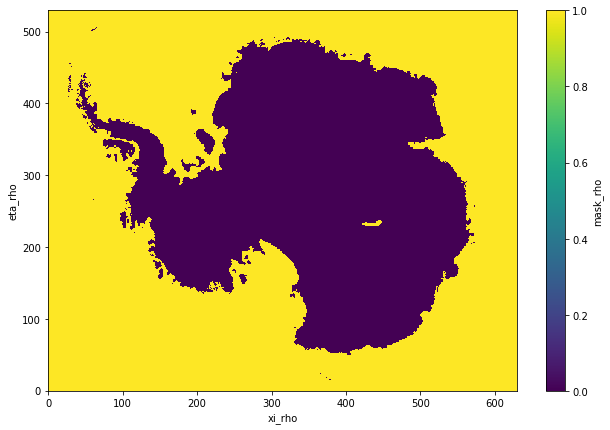

In [19]:
grd_path = os.path.join(os.environ.get("intdir"),'waom10_grd_patched.nc')
grd = xr.open_dataset(grd_path)

plt.close()
grd.mask_rho.plot(size=7)
plt.show()

#mask ostock for smoothing eta_min, eta_max, xi_min, xi_max
vostock = [200,275,375,475]
#vostock = [2000,2750,3750,4750]

out_path = os.path.join(os.environ.get('prodir'),'waom10_grd.nc')

In [20]:
def smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix,rounds):
    """
    This program use the Mellor-Ezer-Oey method (Mellor et al., 1994).
    The bathymetry is optimized for a given rx0 factor by doing a sequence
    of increase/decrease at adjacent cells.

    Usage:
    RetBathy, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(MSK, Hobs, rx0max, AreaMatrix)

    ---MSK(eta_rho,xi_rho) is the mask of the grid
         1 for sea
         0 for land
    ---Hobs(eta_rho,xi_rho) is the raw depth of the grid
    ---rx0max is the target rx0 roughness factor
    ---AreaMatrix(eta_rho,xi_rho) is the matrix of areas at
       rho-points.
    """

    eta_rho, xi_rho = Hobs.shape

    ListNeigh = np.array([[1, 0],
                          [0, 1],
                          [-1, 0],
                          [0, -1]])

    RetBathy = Hobs.copy()

    HmodifVal = 0
    TheMultiplier = (1 - rx0max) / (1 + rx0max)
    tol = 0.000001
    ValueFct = 0

    #while(True):
    for round in log_progress(range(rounds),name='steps'):
        eta=[]
        xi=[]
        IsFinished = 1
        for iEta in range(eta_rho):
            for iXi in range(xi_rho):
                if (MSK[iEta, iXi] == 1):
                    Area = AreaMatrix[iEta, iXi]
                    for ineigh in range(4):
                        iEtaN = iEta + ListNeigh[ineigh,0]
                        iXiN = iXi + ListNeigh[ineigh,1]
                        if (iEtaN <= eta_rho-1 and iEtaN >= 0 and iXiN <= xi_rho-1 \
                            and iXiN >= 0 and MSK[iEtaN,iXiN] == 1):
                            AreaN = AreaMatrix[iEtaN,iXiN]
                            LowerBound = RetBathy[iEtaN,iXiN] * TheMultiplier
                            if ((RetBathy[iEta,iXi] - LowerBound) < -tol):
                                IsFinished = 0
                                h = (TheMultiplier * RetBathy[iEtaN,iXiN] - RetBathy[iEta,iXi]) \
                                         / (AreaN + TheMultiplier * Area)
                                RetBathy[iEta,iXi] = RetBathy[iEta,iXi] + AreaN * h
                                RetBathy[iEtaN,iXiN] = RetBathy[iEtaN,iXiN] - Area * h
                                HmodifVal = HmodifVal + abs(h)
                                ValueFct = ValueFct + abs(h) * (Area + AreaN)
                                eta.append(iEta)
                                xi.append(iXi)
                                
        #H = AreaMatrix * Hobs * MSK
        #TheBathymetry1 = H.sum()
        #H = AreaMatrix * RetBathy * MSK
        #TheBathymetry2 = H.sum()
        #DeltaBathymetry = TheBathymetry1 - TheBathymetry2
        #print('DeltaBathymetry = ', DeltaBathymetry)                       
        if (IsFinished == 1):
            break
            
    H = AreaMatrix * Hobs * MSK
    TheBathymetry1 = H.sum()
    H = AreaMatrix * RetBathy * MSK
    TheBathymetry2 = H.sum()
    DeltaBathymetry = TheBathymetry1 - TheBathymetry2
    print('DeltaBathymetry = ', DeltaBathymetry)

    return RetBathy, HmodifVal, ValueFct,eta,xi


In [21]:
RoughMat_old = bathy_smoother.bathy_tools.RoughnessMatrix(grd.h.values,grd.mask_rho.values)
print('Max Roughness value is: ', RoughMat_old.max())

Max Roughness value is:  0.945179879665


In [22]:
Area = 1/(grd.pm.values*grd.pn.values)
mask = grd.mask_rho.values
mask[vostock[0]:vostock[1],vostock[2]:vostock[3]] = 0

In [23]:
RetBathy, HmodifVal, ValueFct,eta,xi = smoothing_PlusMinus_rx0(mask,grd.h.values,0.3,Area,150)

VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

DeltaBathymetry =  -1417304.0


In [24]:
RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(RetBathy,grd.mask_rho.values)
print('Max Roughness value is: ', RoughMat.max())

Max Roughness value is:  0.300000041723


<IPython.core.display.Javascript object>


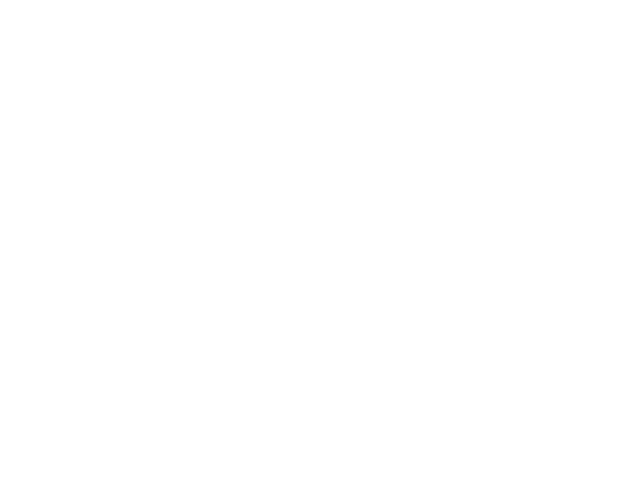

In [25]:
%matplotlib notebook
plt.close()
plt.pcolormesh(RoughMat-RoughMat_old,vmin=-0.1,vmax=0.1)
plt.colorbar()
plt.show()

In [26]:
bed = RetBathy.copy()
ice = grd.zice.values.copy()
#set bed minimum depth to 10 cm
bed[bed<0.1]= 0.1
#set ice draft at these places to zero 
ice[bed<0.1] = 0.0

#set water column thickness to a small positive value (ROMS don't like when bed = ice draft)
wct = (bed+ice).copy()
ice[wct<=0] = -bed[wct<=0] + 0.1

grd.h.values = bed
grd.zice.values = ice


mask = np.ones_like(bed) 
mask[(wct<20.0)]=0
mask[grd.mask_rho==0]=0

umask,vmask,pmask = uvp_masks(mask)

grd.mask_rho.values = mask
grd.mask_u.values = umask
grd.mask_v.values = vmask
grd.mask_psi.values = pmask

<IPython.core.display.Javascript object>


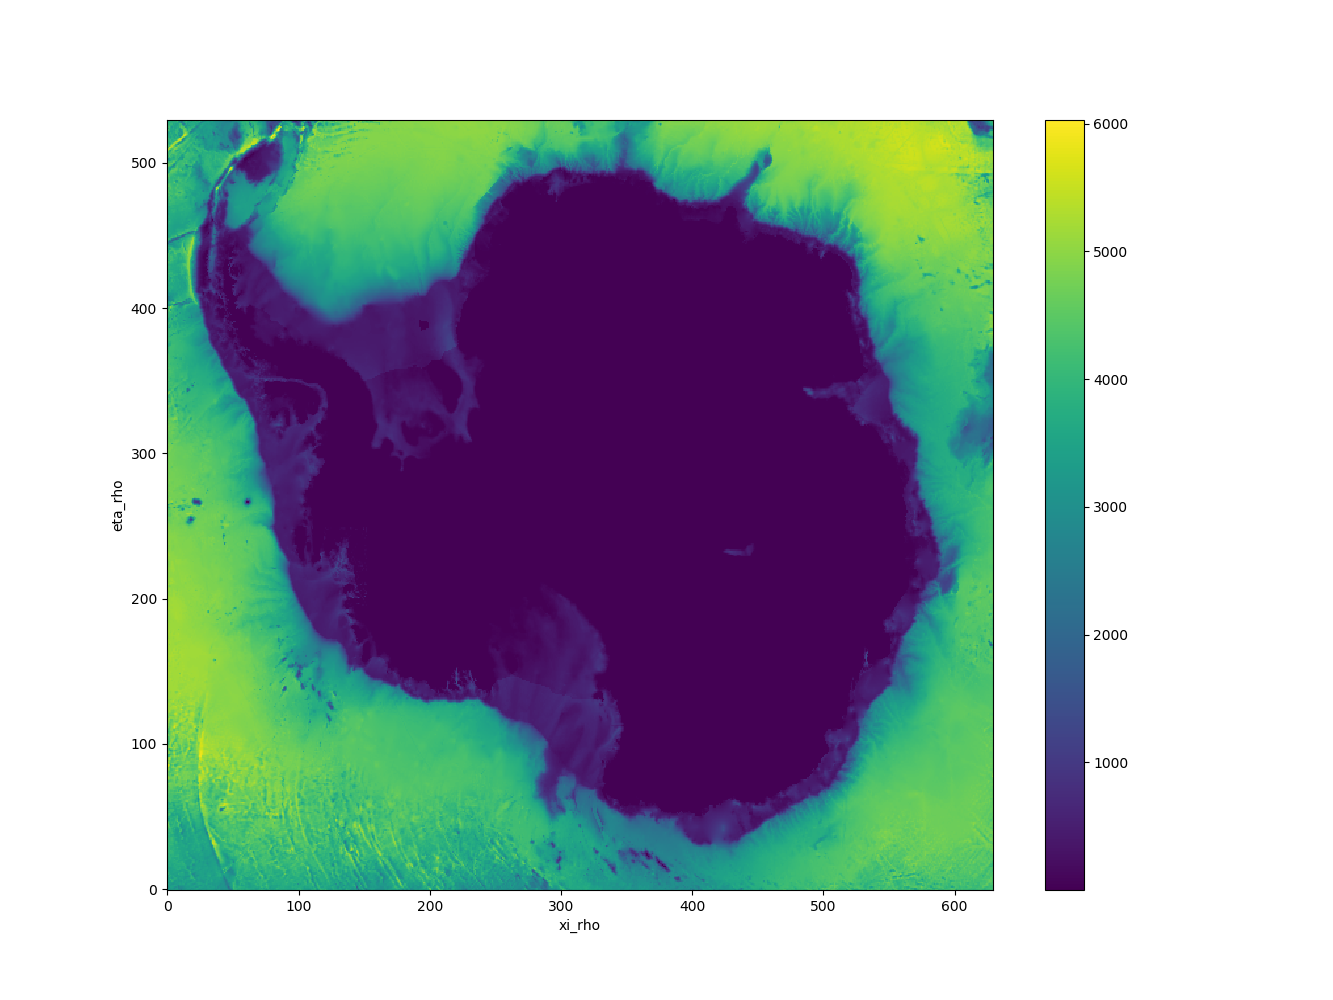

In [27]:
plt.close()
(grd.h+grd.zice).plot(size=10)
plt.show()

In [28]:
print("write smoothed bathy to ",out_path)
grd.to_netcdf(out_path)

write smoothed bathy to  /home/ubuntu/bigStick/tidal_melting/data/preprocessing/processed/waom10_grd.nc


In [ ]:
path = os.path.join(os.environ.get('prodir'),'waom4_grd.nc')
grd = xr.open_dataset(path)

In [ ]:
plt.close()
(grd.h+grd.zice).where(grd.mask_rho).plot()
plt.show()

In [ ]:
RoughMat = bathy_smoother.bathy_tools.RoughnessMatrix(grd.h.values,grd.mask_rho.values)
print('Max Roughness value is: ', RoughMat.max())